In [1]:
import os
import sys
project_dir = os.path.dirname(os.getcwd())
sys.path.append(project_dir)

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = torch.Generator().manual_seed(42)
print(device)

cuda


# Data Ingestion

In [3]:
from data.mnist import get_mnist_pipeline

train_loader, val_loader, test_loader = get_mnist_pipeline(batch_size=32)
for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    if i == 0:
        print("Shape of training batch inputs:", inputs.shape)
        print("Shape of training batch labels:", labels.shape)
        break
for i, data in enumerate(val_loader, 0):
    inputs, labels = data
    if i == 0:
        print("Shape of validation batch inputs:", inputs.shape)
        print("Shape of validation batch labels:", labels.shape)
        break
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    if i == 0:
        print("Shape of testing batch inputs:", inputs.shape)
        print("Shape of testing batch labels:", labels.shape)
        break
print("MNIST dataset loaded into PyTorch DataLoaders.")

Shape of training batch inputs: torch.Size([32, 1, 28, 28])
Shape of training batch labels: torch.Size([32])
Shape of validation batch inputs: torch.Size([32, 1, 28, 28])
Shape of validation batch labels: torch.Size([32])
Shape of testing batch inputs: torch.Size([32, 1, 28, 28])
Shape of testing batch labels: torch.Size([32])
MNIST dataset loaded into PyTorch DataLoaders.


# Model

In [4]:
import torch
import torch.optim as optim
import models.baseline as mlp
from utils.summary import get_model_stats

teacher = mlp.mnist1200().to(device)
student = mlp.mnist400().to(device)
smaller = mlp.mnist400().to(device)

sample = torch.randn(1, 1, 28, 28).to(device)
with torch.no_grad():
    print("Teacher model stats:")
    pred = teacher(sample)
    for name, param in get_model_stats(teacher, sample.shape).items():
        print(f"{name}: {param}")
    print("Student model stats:")
    pred = smaller(sample)
    for name, param in get_model_stats(student, sample.shape).items():
        print(f"{name}: {param}")

Teacher model stats:
flops: 2392800
params: 2395210
Student model stats:
flops: 477600
params: 478410


# Training Loop

In [ ]:
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from configs.config import Config
from utils.losses import Accuracy
import itertools


def train_model(train_loader: DataLoader, model: nn.Module, criterion: nn.Module, optimizer: nn.Module,
                scheduler: nn.Module=None, device: str='cpu') -> list:
    """
    Train the model for one epoch.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the training data.
        optimizer: Optimizer for updating model parameters.
        criterion: Loss function.
        device: Device to run the training on ('cpu' or 'cuda').

    Returns:
        list: Collection of train losses.
    """
    model.train()
    epoch_losses = []
    for inputs, targets in tqdm.tqdm(train_loader, desc='training...', file=sys.stdout):
        inputs = inputs.to(device)
        targets = targets.to(device)
        preds = model(inputs)
        loss = criterion(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(loss.item())
        elif scheduler:
            scheduler.step()
    return epoch_losses


def evaluate_model(val_loader: DataLoader, model: nn.Module, criterion: nn.Module, device: str='cpu') -> list:
    """
    Evaluate the model on validation data.

    Args:
        model: The PyTorch model to evaluate.
        val_loader: DataLoader for the validation data.
        criterion: Loss function.
        device: Device to run the evaluation on ('cpu' or 'cuda').

    Returns:
        list: Collection of metrics.
    """
    model.eval()
    epoch_metrics = []
    with torch.no_grad():
        for inputs, targets in tqdm.tqdm(val_loader, desc='evaluating...', file=sys.stdout):
            inputs = inputs.to(device)
            targets = targets.to(device)
            preds = model(inputs)
            loss = criterion(preds, targets)
            epoch_metrics.append(loss.item())
    return epoch_metrics


def train_val(train_loader, val_loader, model, criterion, optimizer, scheduler, device, aux_metrics, path):
    torch.manual_seed(42)
    metrics = {"train_loss": [], "val_loss": []}
    for k in aux_metrics.keys():
        metrics[k] = []
    try:
        best_val_loss = torch.load(path)['val_loss']
    except Exception:
        best_val_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 200

    for epoch in range(epochs):
        train_loss = train_model(train_loader, model, criterion, optimizer, scheduler, device)
        val_loss = evaluate_model(val_loader, model, criterion, device)
        metrics['train_loss'].append(np.mean(train_loss))
        metrics['val_loss'].append(np.mean(val_loss))
        for k, v in aux_metrics.items():
            stat = evaluate_model(val_loader, model, v, device)
            metrics[k].append(np.mean(stat))
        if metrics['val_loss'][-1] < best_val_loss:
            best_val_loss = metrics['val_loss'][-1]
            counter = 0
            print(f"Epoch {epoch+1}: New best val loss: {best_val_loss:.4f}, Accuracy: {metrics['accuracy'][-1]:.2f} saving model...")
            state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'Accuracy': metrics['accuracy'][-1]
            }
            torch.save(state, path)
        else:
            counter += 1
        if counter >= patience:
            print(f"Epoch {epoch+1}: Early stop triggered.")
            break
    return metrics


def _train_val(cfg: Config):    
    """
    Trains and Validates Model using a Config dataclass
    Args:
    Return:
    """
    try:
        best_val_loss = torch.load(cfg.path)['val_loss']
    except Exception:
        best_val_loss = float('inf')
    patience = 10
    counter = 0
    for epoch in range(cfg.epochs):
        # dump config + add device
        train_loss = train_model(**cfg.train_attr)
        val_loss = evaluate_model(**cfg.val_attr)
        # pop metrics from config
        cfg.metrics['train_loss'].append(np.mean(train_loss))
        cfg.metrics['val_loss'].append(np.mean(val_loss))
        if cfg.metrics['val_loss'][-1] < best_val_loss:
            best_val_loss = cfg.metrics['val_loss'][-1]
            counter = 0
            print(f"Epoch {epoch+1}: New best val loss: {best_val_loss:.4f}, saving model...")
            state = {
                'epoch': epoch,
                'state_dict': cfg.model.state_dict(),
                'optimizer': cfg.optimizer.state_dict(),
                'val_loss': best_val_loss
            }
            torch.save(state, cfg.path)
        else:
            counter += 1
        if counter >= patience:
            print(f"Epoch {epoch+1}: Early stop triggered.")
            break


def grid_search_cv(**kwargs):
    hparams_grid = {
        'learning_rate': [1e-3, 1e-4],
        'batch_size': 32,
        'optimizer': ['Adam', 'RMSprop'],
        'num_epochs': 5
    }

    param_names = list(hparams_grid.keys())
    param_values = list(hparams_grid.values())
    all_combinations = list(itertools.product(*param_values))

    for combo in all_combinations:
        current_hparams = dict(zip(param_names, combo))
        metrics = train_val{**current_hparams, **kwargs}
    return

# Train Teacher

/tmp/ipykernel_66045/2604095539.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_val_loss = torch.load(path)['val_loss']


evaluating...: 100%|██████████| 375/375 [00:02<00:00, 138.46it/s]
Epoch 1: New best val loss: 0.8065, Accuracy: 0.75 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 140.41it/s]
Epoch 4: New best val loss: 0.7968, Accuracy: 0.75 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 140.21it/s]
Epoch 13: New best val loss: 0.7952, Accuracy: 0.75 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 139.75it/s]
Epoch 14: New best val loss: 0.7934, Accuracy: 0.75 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 138.20it/s]
Epoch 24: Early stop triggered.


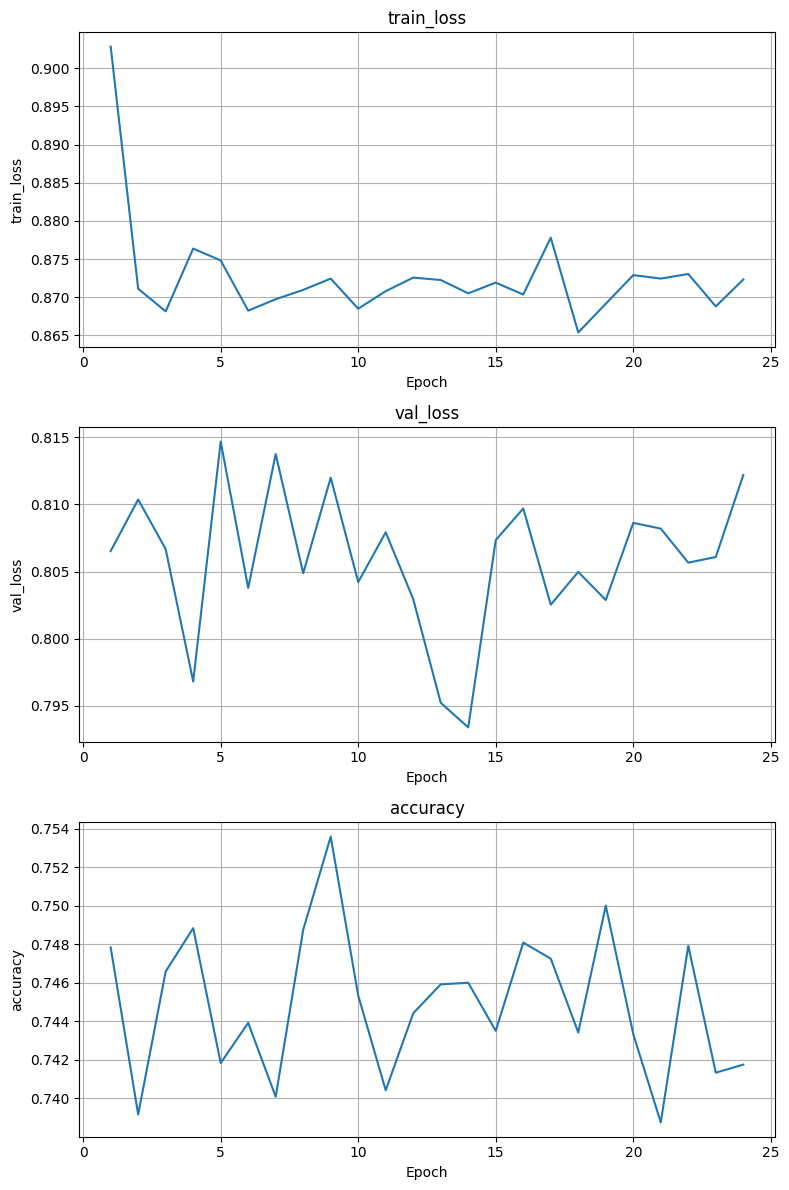

In [6]:
from utils.plots import plot_training_metrics

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher.parameters(), lr=0.005, weight_decay=1e-4)
# optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
aux_metrics = {'accuracy': Accuracy()}
path = '../models/weights/teacher.pth'

metrics = train_val(train_loader, val_loader, teacher, criterion, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

# Train Smaller

/tmp/ipykernel_66045/2604095539.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_val_loss = torch.load(path)['val_loss']


evaluating...: 100%|██████████| 375/375 [00:02<00:00, 143.70it/s]
Epoch 1: New best val loss: 0.8470, Accuracy: 0.74 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 136.52it/s]
Epoch 2: New best val loss: 0.8462, Accuracy: 0.73 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 142.57it/s]
Epoch 4: New best val loss: 0.8407, Accuracy: 0.74 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 142.67it/s]
Epoch 10: New best val loss: 0.8395, Accuracy: 0.75 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 143.77it/s]
Epoch 13: New best val loss: 0.8328, Accuracy: 0.75 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 148.60it/s]
Epoch 14: New best val loss: 0.8286, Accuracy: 0.74 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 142.31it/s]
Epoch 24: Early stop triggered.


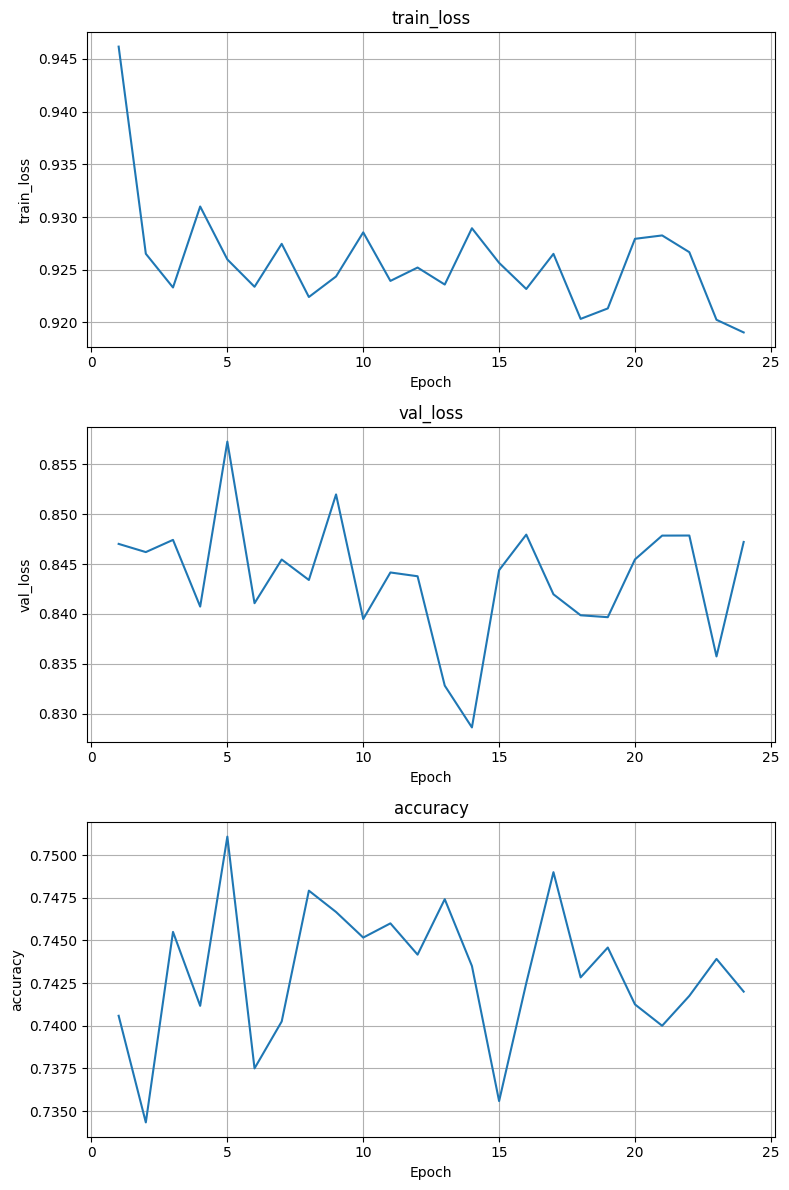

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(smaller.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
aux_metrics = {'accuracy': Accuracy()}
path = '../models/weights/smaller.pth'

metrics = train_val(train_loader, val_loader, smaller, criterion, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

# Distill Student

In [8]:
from utils.losses import DistillationLoss


def distill_model(train_loader: DataLoader, student: nn.Module, teacher: nn.Module, 
                  criterion: nn.Module, optimizer: nn.Module,
                  scheduler: nn.Module=None, device: str='cpu') -> list:
    """
    Train the student model for one epoch using knowledge distillation.

    Args:
        train_loader: DataLoader for the training data.
        student_model: The PyTorch student model to train.
        teacher_model: The PyTorch teacher model (should be in eval mode).
        optimizer: Optimizer for updating student model parameters.
        criterion: Distillation loss function (e.g., DistillationLoss).
        device: Device to run the training on ('cpu' or 'cuda').

    Returns:
        list: Collection of train losses.
    """
    student.train()
    teacher.eval()  # Ensure teacher model is in evaluation mode
    epoch_losses = []
    for inputs, targets in tqdm.tqdm(train_loader, desc='distilling...', file=sys.stdout):
        inputs = inputs.to(device)
        targets = targets.to(device)
        # preds
        student_preds = student(inputs)
        with torch.no_grad():
            teacher_preds = teacher(inputs)
        # distillation loss
        loss = criterion(student_preds, teacher_preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(loss.item())
        elif scheduler:
            scheduler.step()
    return epoch_losses


def distill(train_loader, val_loader, student, teacher, loss, criterion, optimizer, scheduler, device, aux_metrics, path):
    torch.manual_seed(42)
    metrics = {"train_loss": [], "val_loss": []}
    for k in aux_metrics.keys():
        metrics[k] = []
    try:
        best_val_loss = torch.load(path)['val_loss']
    except Exception:
        best_val_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 200

    for epoch in range(epochs):
        train_loss = distill_model(train_loader, student, teacher, loss, optimizer, scheduler, device)
        val_loss = evaluate_model(val_loader, student, criterion, device)
        metrics['train_loss'].append(np.mean(train_loss))
        metrics['val_loss'].append(np.mean(val_loss))
        for k, v in aux_metrics.items():
            stat = evaluate_model(val_loader, student, v, device)
            metrics[k].append(np.mean(stat))
        if metrics['val_loss'][-1] < best_val_loss:
            best_val_loss = metrics['val_loss'][-1]
            counter = 0
            print(f"Epoch {epoch+1}: New best val loss: {best_val_loss:.4f}, Accuracy: {metrics['accuracy'][-1]:.2f} saving model...")
            state = {
                'epoch': epoch,
                'state_dict': student.state_dict(),
                'optimizer': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'Accuracy': metrics['accuracy'][-1]
            }
            torch.save(state, path)
        else:
            counter += 1
        if counter >= patience:
            print(f"Epoch {epoch+1}: Early stop triggered.")
            break
    return metrics


/tmp/ipykernel_66045/2161462799.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)[

evaluating...: 100%|██████████| 375/375 [00:02<00:00, 139.89it/s]
Epoch 1: New best val loss: 0.8937, Accuracy: 0.72 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 133.65it/s]
Epoch 4: New best val loss: 0.8876, Accuracy: 0.72 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 137.33it/s]
Epoch 10: New best val loss: 0.8862, Accuracy: 0.72 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 137.61it/s]
Epoch 13: New best val loss: 0.8841, Accuracy: 0.72 saving model...
evaluating...: 100%|██████████| 375/375 [00:03<00:00, 123.59it/s]
Epoch 14: New best val loss: 0.8804, Accuracy: 0.72 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 142.89it/s]
Epoch 24: Early stop triggered.


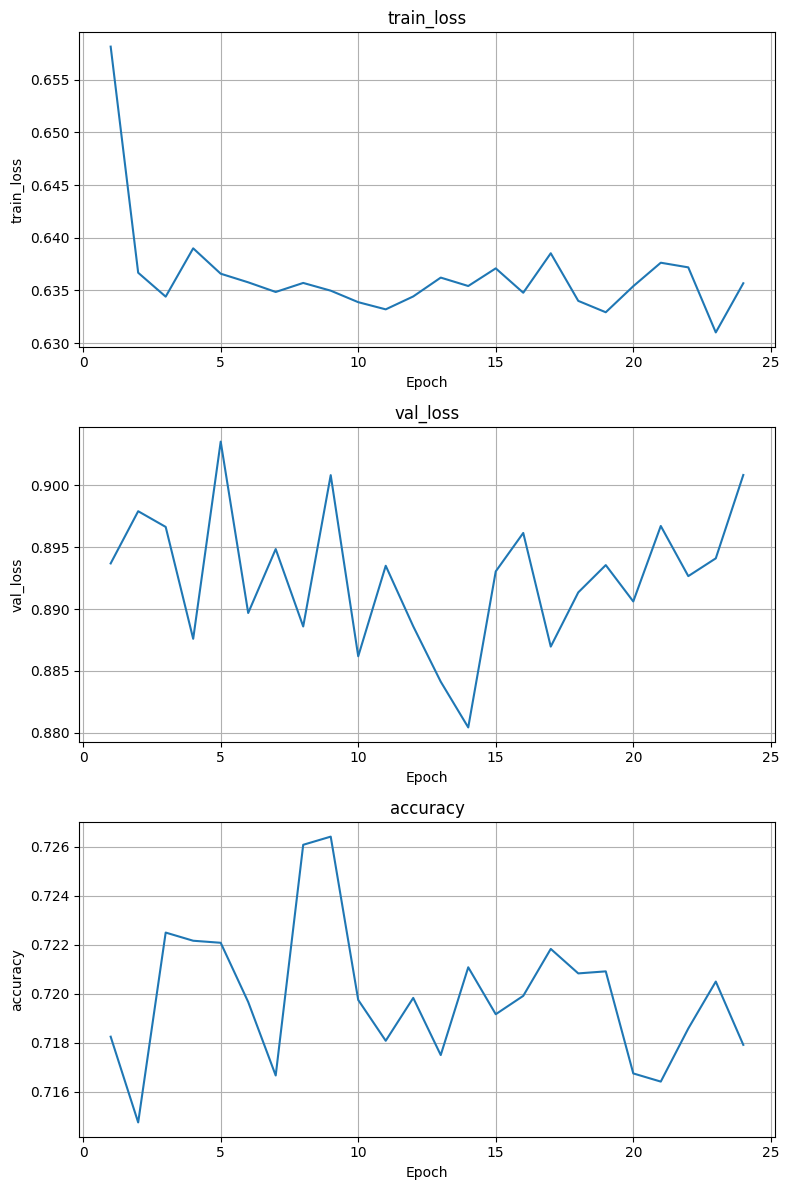

In [9]:
T = 20
criterion = DistillationLoss(T=T)
crossentropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.005)  # remove regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
aux_metrics = {'accuracy': Accuracy()}
path = f'../models/weights/student{T}.pth'
teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)['state_dict'])

metrics = distill(train_loader, val_loader, student, teacher, criterion, crossentropy, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

## Temperature Testing

/tmp/ipykernel_66045/644870831.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)['

evaluating...: 100%|██████████| 375/375 [00:02<00:00, 144.33it/s]
Epoch 1: New best val loss: 0.7684, Accuracy: 0.77 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 148.05it/s]
Epoch 4: New best val loss: 0.7617, Accuracy: 0.77 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 140.64it/s]
Epoch 13: New best val loss: 0.7608, Accuracy: 0.77 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 163.66it/s]
Epoch 14: New best val loss: 0.7567, Accuracy: 0.77 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 136.85it/s]
Epoch 24: Early stop triggered.


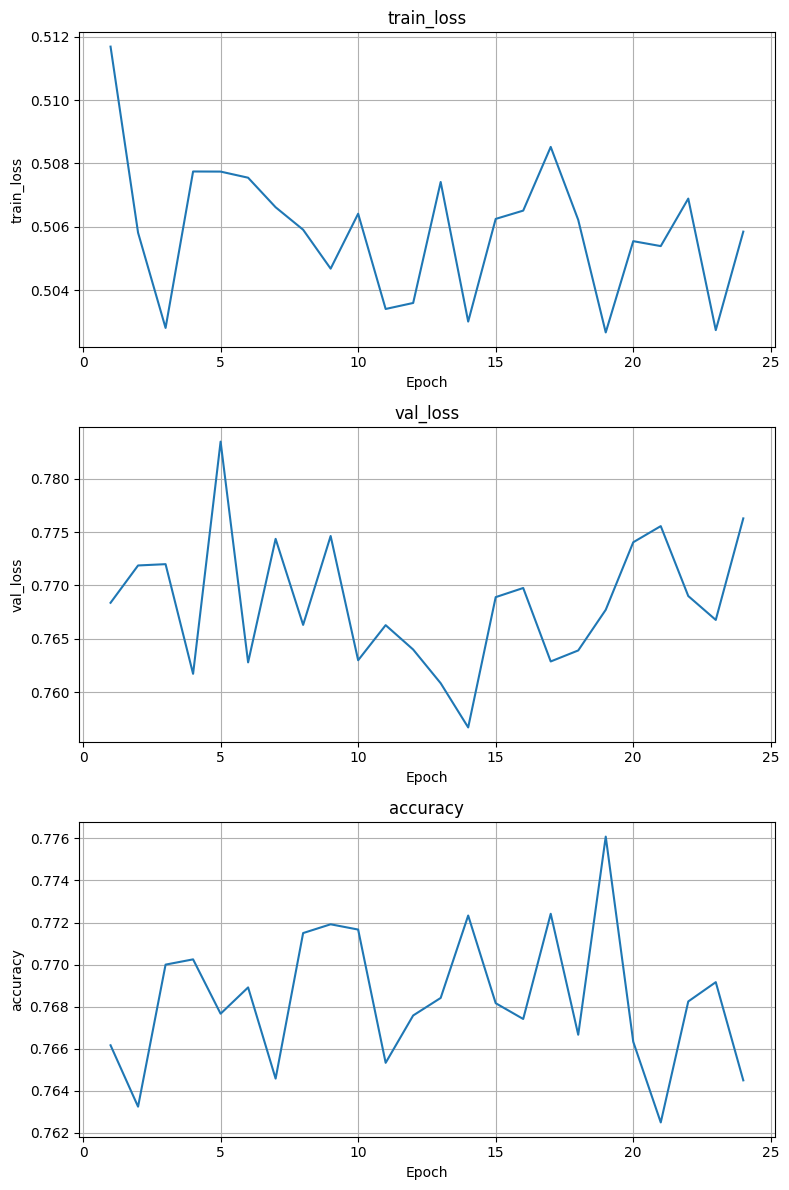

In [10]:
T = 1
criterion = DistillationLoss(T=T)
crossentropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.005)  # remove regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
aux_metrics = {'accuracy': Accuracy()}
path = f'../models/weights/student{T}.pth'
teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)['state_dict'])

metrics = distill(train_loader, val_loader, student, teacher, criterion, crossentropy, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

/tmp/ipykernel_66045/1994872406.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)[

evaluating...: 100%|██████████| 375/375 [00:02<00:00, 144.54it/s]
Epoch 1: New best val loss: 0.7927, Accuracy: 0.77 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 144.72it/s]
Epoch 3: New best val loss: 0.7919, Accuracy: 0.77 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 144.20it/s]
Epoch 4: New best val loss: 0.7818, Accuracy: 0.77 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 139.92it/s]
Epoch 13: New best val loss: 0.7814, Accuracy: 0.77 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 148.21it/s]
Epoch 23: Early stop triggered.


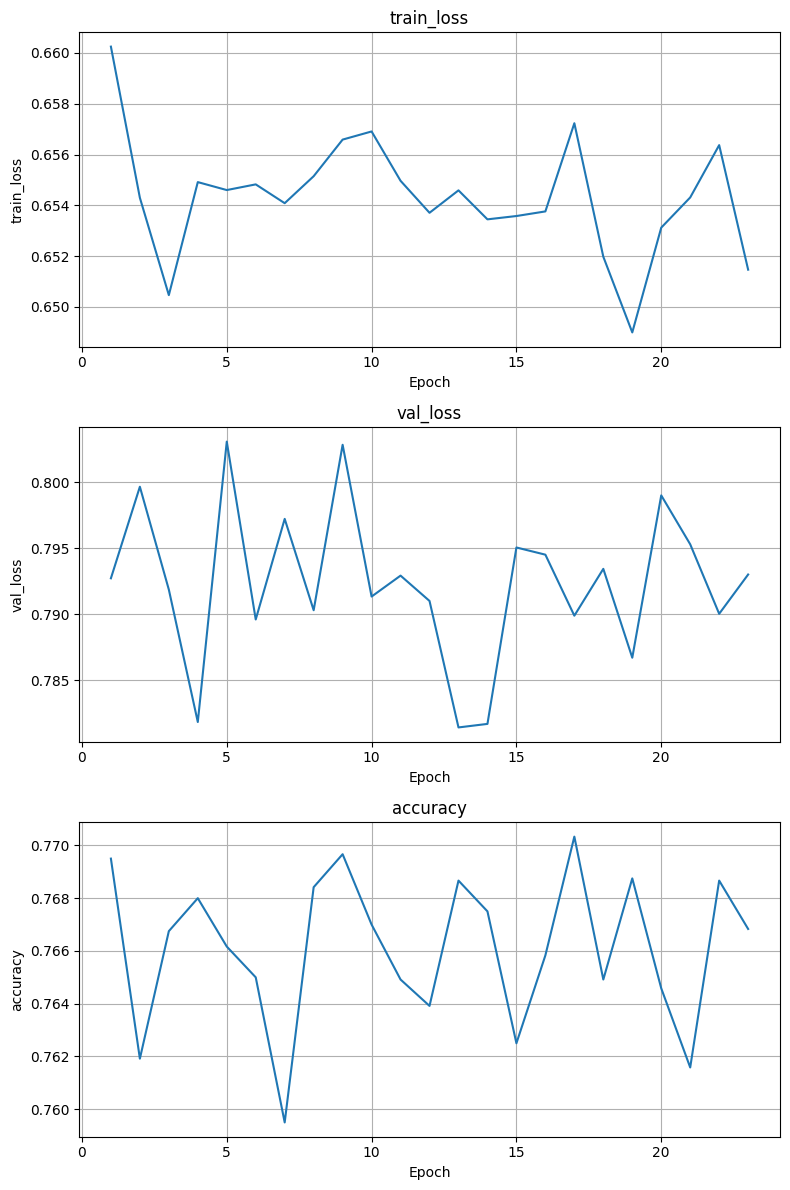

In [11]:
T = 5
criterion = DistillationLoss(T=T)
crossentropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.005)  # remove regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
aux_metrics = {'accuracy': Accuracy()}
path = f'../models/weights/student{T}.pth'
teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)['state_dict'])

metrics = distill(train_loader, val_loader, student, teacher, criterion, crossentropy, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

# Compare: Teacher, Smaller, Student

In [17]:
def eval(test_loader, model, device, aux_metrics={}):
    metrics = {}
    for k, m in aux_metrics.items():
        metrics[k] = np.mean(evaluate_model(test_loader, model, m, device))
    return metrics        

In [22]:
teacher_state = torch.load('../models/weights/teacher.pth', map_location=device)
student_state = torch.load('../models/weights/student20.pth', map_location=device)
smaller_state = torch.load('../models/weights/smaller.pth', map_location=device)
aux_metrics = {'crossentropy': nn.CrossEntropyLoss(), 'accuracy': Accuracy()}

teacher.load_state_dict(teacher_state['state_dict'])
student.load_state_dict(student_state['state_dict'])
smaller.load_state_dict(smaller_state['state_dict'])

# work on test sets
teacher_metrics = eval(test_loader, teacher, device, aux_metrics)
student_metrics = eval(test_loader, student, device, aux_metrics)
smaller_metrics = eval(test_loader, smaller, device, aux_metrics)

# look at the best val_losses
print(f"Teacher: Val loss: {teacher_state['val_loss']:.4f}, Accuracy: {teacher_state['Accuracy']:.4f}")
print(f"Student: Val loss: {student_state['val_loss']:.4f}, Accuracy: {student_state['Accuracy']:.4f}")
print(f"Smaller: Val loss: {smaller_state['val_loss']:.4f}, Accuracy: {smaller_state['Accuracy']:.4f}")
print("Test results:")
for k in aux_metrics.keys():
    print(f"""{k}: 
          Teacher = {teacher_metrics[k]:.4f}, 
          Student = {student_metrics[k]:.4f}, 
          Smaller = {smaller_metrics[k]:.4f}""")

/tmp/ipykernel_66045/235680923.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_state = torch.load('../models/weights/teacher.pth', map_location=device)
/tmp/ipyk

evaluating...: 100%|██████████| 313/313 [00:02<00:00, 146.44it/s]
Teacher: Val loss: 0.7934, Accuracy: 0.7460
Student: Val loss: 0.8804, Accuracy: 0.7211
Smaller: Val loss: 0.8286, Accuracy: 0.7435
Test results:
crossentropy: 
          Teacher = 0.7991, 
          Student = 0.8911, 
          Smaller = 0.8309
accuracy: 
          Teacher = 0.7480, 
          Student = 0.7257, 
          Smaller = 0.7522


# Transfer Set Training

In [ ]:
# transfer set
train_loader, val_loader, test_loader = get_mnist_pipeline(batch_size=32, exclude=set(0))
teacher = mlp.mnist1200().to(device)
student = mlp.mnist400().to(device)
smaller = mlp.mnist400().to(device)